In [1]:
# Some imports that you might need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('Reviews.csv')
print(df.shape)

(568454, 10)


In [4]:
!python -m pip install textblob

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 17.0 MB/s eta 0:00:0000:01


In [5]:
from textblob import TextBlob

In [6]:
!pip install afinn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53429 sha256=a4a0fca17328e3d60fecdad10f8ea59835efc76c5060857e1c5b4f3df458b000
  Stored in directory: /home/ec2-user/.cache/pip/wheels/f0/cb/2b/11d9c0e366428dd38f54a5e14c6252edcc669feec72c2d5ef8
Successfully built afinn


In [7]:
from afinn import Afinn

### Data Exploration

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
len(df)

568454

In [20]:
df['Summary'] = df['Summary'].apply(lambda x: str(x))
df['Text'] = df['Text'].apply(lambda x: str(x))

In [6]:
for col in df:
    print(col + " " + str(len(df[col].unique())))

Id 568454
ProductId 74258
UserId 256059
ProfileName 218417
HelpfulnessNumerator 231
HelpfulnessDenominator 234
Score 5
Time 3168
Summary 295743
Text 393579
HelpfulnessProp 952


In [7]:
(df['Summary'].str.len()).mean()

23.446857731951507

In [8]:
(df['Text'].str.len()).mean()

436.22208305333413

<AxesSubplot:>

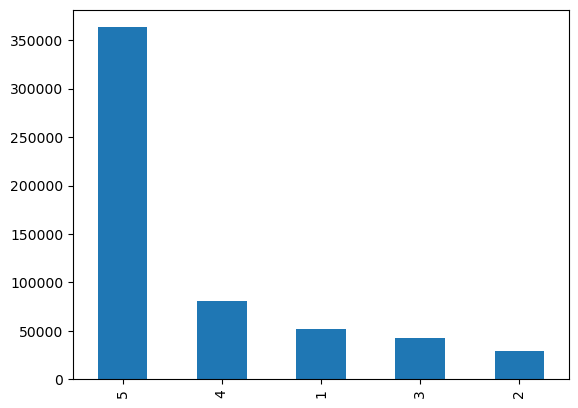

In [9]:
df['Score'].value_counts().plot(kind='bar')

### Feature Engineering

In [10]:
df["HelpfulnessProp"] = df["HelpfulnessNumerator"] / df["HelpfulnessDenominator"]

In [31]:
df["HighScore"] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

In [21]:
df['sum_char_count'] = df['Summary'].apply(lambda x: len(x))
df['sum_word_count'] = df['Summary'].apply(lambda x: len(x.split()))

df['text_char_count'] = df['Text'].apply(lambda x: len(x))
df['text_word_count'] = df['Text'].apply(lambda x: len(x.split()))

In [22]:
punctuation = string.punctuation
stop_words = list(set(stopwords.words('english')))
df['text_stopword_count'] = df['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))
df['text_punctuation_count'] = df['Text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
df['sum_punctuation_count'] = df['Summary'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 

In [24]:
df['sum_word_density'] = df['sum_char_count'] / (df['sum_word_count']+1)
df['text_word_density'] = df['text_char_count'] / (df['text_word_count']+1)

In [50]:
def get_polarity(text):
    try:
        textblob = TextBlob(text)
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

def get_subjectivity(text):
    try:
        textblob = TextBlob(text)
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

In [51]:
df['sum_polarity'] = df['Summary'].apply(get_polarity)
df['sum_subjectivity'] = df['Summary'].apply(get_subjectivity)

In [52]:
df['text_polarity'] = df['Text'].apply(get_polarity)
df['text_subjectivity'] = df['Text'].apply(get_subjectivity)

In [55]:
afinn = Afinn()
df['sum_sentiment_score'] = df['Summary'].apply(afinn.score)
df['text_sentiment_score'] = df['Text'].apply(afinn.score)

In [56]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,text_punctuation_count,sum_punctuation_count,sum_word_density,text_word_density,sum_polarity,sum_subjectivity,text_polarity,text_subjectivity,sum_sentiment_score,text_sentiment_score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,...,3,0,4.200000,5.367347,0.70,0.60,0.450000,0.433333,5.0,16.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,...,7,0,4.250000,5.937500,0.00,0.00,-0.033333,0.762963,0.0,-2.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,...,18,2,4.200000,5.357895,0.00,0.00,0.133571,0.448571,3.0,3.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,...,5,0,4.666667,5.214286,0.00,0.00,0.166667,0.533333,0.0,3.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,...,5,0,3.666667,5.000000,0.80,0.75,0.483333,0.637500,3.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,...,8,0,3.800000,5.518519,0.00,0.00,0.365000,0.605000,0.0,11.0
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,...,9,0,6.000000,5.361702,-0.75,0.75,-0.208333,0.408333,-2.0,-3.0
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",...,11,0,4.800000,5.552239,1.00,1.00,-0.021875,0.418750,3.0,4.0
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,...,3,0,5.666667,5.555556,0.50,1.00,0.517857,0.678571,4.0,15.0


In [57]:
df.to_csv("Engineered_Reviews.csv")

### Manually Engineered Modeling

In [17]:
df = pd.read_csv("Engineered_Reviews.csv")

In [18]:
df.columns

Index(['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'HelpfulnessProp', 'sum_char_count',
       'sum_word_count', 'text_char_count', 'text_word_count',
       'text_stopword_count', 'text_punctuation_count',
       'sum_punctuation_count', 'sum_word_density', 'text_word_density',
       'sum_polarity', 'sum_subjectivity', 'text_polarity',
       'text_subjectivity', 'sum_sentiment_score', 'text_sentiment_score'],
      dtype='object')

In [19]:
mean = df.HelpfulnessProp.mean()
df['HelpfulnessProp'].fillna(value=mean, inplace=True)

In [20]:
X = df.drop(columns = ["Unnamed: 0", "Id", "ProductId", "UserId", "ProfileName", "Score", "Time", "Summary", "Text"])

#### Multiclass Classification

In [21]:
Y = df["Score"].astype(str)
X = X.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

KNN

In [130]:
#Scale X
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [131]:
nn = KNeighborsClassifier(n_neighbors=5)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)

In [132]:
f1_score(y_test, y_pred, average='weighted')

0.7161692970372344

In [133]:
nn = KNeighborsClassifier(n_neighbors=10)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)

In [134]:
f1_score(y_test, y_pred, average='weighted')

0.6891569688609583

In [135]:
nn = KNeighborsClassifier(n_neighbors=6)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)
f1_score(y_test, y_pred, average='weighted')

0.7087338334681963

In [137]:
nn = KNeighborsClassifier(n_neighbors=4)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)
f1_score(y_test, y_pred, average='weighted')

0.7189004495639094

In [138]:
nn = KNeighborsClassifier(n_neighbors=3)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)
f1_score(y_test, y_pred, average='weighted')

0.7261916139899334

In [139]:
nn = KNeighborsClassifier(n_neighbors=2)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)
f1_score(y_test, y_pred, average='weighted')

0.7009400883137489

In [140]:
nn = KNeighborsClassifier(n_neighbors=7)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)
f1_score(y_test, y_pred, average='weighted')

0.7029930351094281

Text(0.5, 1.0, 'Number of Neighbors vs. F1 Score')

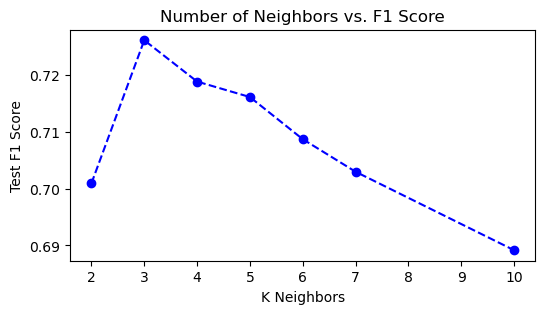

In [2]:
neighbors = [2,3,4,5,6,7,10]
f1_test = [0.7009400883137489, 0.7261916139899334, 0.7189004495639094, 0.7161692970372344, 0.7087338334681963, 0.7029930351094281, 0.6891569688609583]
plt.figure(figsize=(6,3))
plt.plot(neighbors, f1_test, '--bo')
plt.xlabel("K Neighbors")
plt.ylabel("Test F1 Score")
plt.title("Number of Neighbors vs. F1 Score")

Random Forest

In [49]:
params = {
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.5938744046270403

In [50]:
params = {
    "n_estimators": 100,
    "max_depth": 11,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.604665324988109

In [55]:
params = {
    "n_estimators": 100,
    "max_depth": 12,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.6184981301518976

In [54]:
params = {
    "n_estimators": 100,
    "max_depth": 15,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.6681434673195206

In [58]:
params = {
    "n_estimators": 100,
    "max_depth": 20,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7395095079986637

In [52]:
params = {
    "n_estimators": 100,
    "max_depth": 12,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.6194655419667296

In [51]:
params = {
    "n_estimators": 100,
    "max_depth": 15,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.6691405449441674

In [53]:
params = {
    "n_estimators": 100,
    "max_depth": 20,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.74340910536903

In [56]:
params = {
    "n_estimators": 100,
    "max_depth": 18,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7183017238302456

In [57]:
params = {
    "n_estimators": 100,
    "max_depth": 22,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7618215645888468

In [59]:
params = {
    "n_estimators": 100,
    "max_depth": 25,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7790411014217843

In [62]:
accuracy_score(y_test, y_pred)

0.8040084907762493

In [63]:
params = {
    "n_estimators": 100,
    "max_depth": 25,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7814360830804621

In [64]:
accuracy_score(y_test, y_pred)

0.805697263952902

In [65]:
params = {
    "n_estimators": 100,
    "max_depth": 28,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7873840755596045

In [66]:
accuracy_score(y_test, y_pred)

0.8099543796690474

In [71]:
params = {
    "n_estimators": 100,
    "max_depth": 28,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7884346831373298

In [72]:
accuracy_score(y_test, y_pred)

0.8105524868357785

In [67]:
params = {
    "n_estimators": 100,
    "max_depth": 30,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7895273332066665

In [68]:
accuracy_score(y_test, y_pred)

0.8113265078750777

In [69]:
params = {
    "n_estimators": 100,
    "max_depth": 30,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7903040932875146

In [70]:
accuracy_score(y_test, y_pred)

0.8119246150418089

In [73]:
params = {
    "n_estimators": 100,
    "max_depth": 32,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7905797750538617

In [74]:
accuracy_score(y_test, y_pred)

0.8121357116888904

In [75]:
params = {
    "n_estimators": 100,
    "max_depth": 32,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.790740672756191

In [76]:
accuracy_score(y_test, y_pred)

0.8120418909568542

In [79]:
params = {
    "n_estimators": 100,
    "max_depth": 32,
    "min_samples_split": 4,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7895256528900332

In [77]:
params = {
    "n_estimators": 100,
    "max_depth": 35,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.791293614808889

In [16]:
params = {
    "n_estimators": 100,
    "max_depth": 38,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7909964136050438

In [17]:
params = {
    "n_estimators": 100,
    "max_depth": 38,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7900379718593276

In [20]:
params = {
    "n_estimators": 100,
    "max_depth": 40,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params) ## THE BEST!
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7916055957564837

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
accuracy_score(y_test, y_pred)

0.812698636081108

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
cm

In [26]:
import seaborn as sns

In [29]:
cm

array([[ 6039,   166,   102,    31,  1462],
       [  983,  1943,   128,    50,  1342],
       [  610,   102,  2717,   156,  2728],
       [  313,    48,   141,  5018,  6477],
       [  658,    72,   139,   263, 53581]])

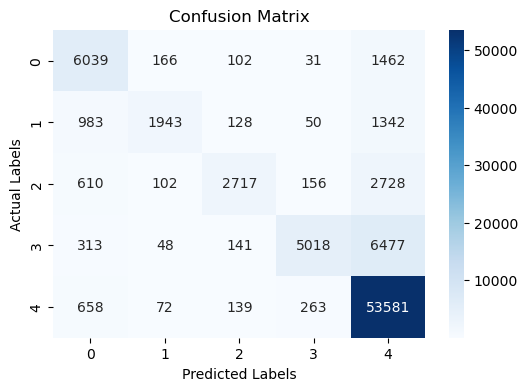

In [33]:
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap='Blues', fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()   

In [18]:
params = {
    "n_estimators": 100,
    "max_depth": 45,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7915800104408862

In [19]:
params = {
    "n_estimators": 100,
    "max_depth": 45,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.790119852198609

In [12]:
params = {
    "n_estimators": 100,
    "max_depth": 50,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7910739600061333

In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 50,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7904584055309829

In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 60,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7912845231037056

In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 60,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.7896082500094672

In [50]:
max_depth_3 = [20, 22, 25, 28, 30, 32, 35, 38, 40, 50, 60, 45]
f1_score_3 = [ 0.74341, 0.76182, 0.77904, 0.78738, 0.78953, 0.79058, 
           0.79129, 0.791, 0.79161, 0.79107, 0.79128, 0.79158]
max_depth_5 = [20, 38, 50, 60, 45]
f1_score_5 = [0.73951, 0.79001, 0.79046, 0.78961, 0.79012]

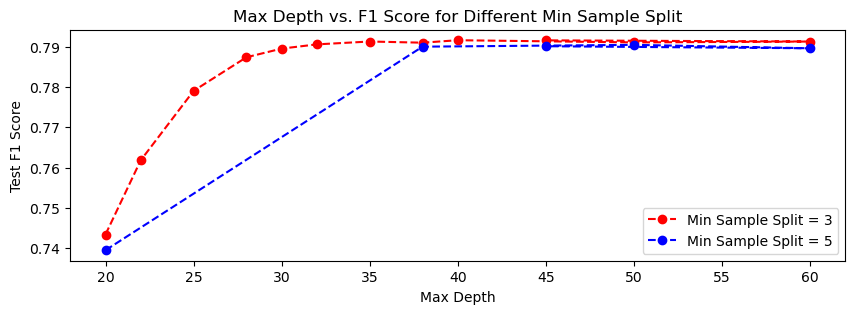

In [52]:
plt.figure(figsize=(10,3))
plt.plot(max_depth_3, f1_score_3, '--ro', label = "Min Sample Split = 3")
plt.plot(max_depth_5, f1_score_5, '--bo', label = "Min Sample Split = 5")
plt.xlabel("Max Depth")
plt.ylabel("Test F1 Score")
plt.title("Max Depth vs. F1 Score for Different Min Sample Split")
plt.legend(loc='lower right')

#### Binary Classification (1, 2, 3) vs. (4, 5)

In [23]:
df["HighScore"] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)
Y = df["HighScore"].astype(str)

KNN

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

In [55]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
nn = KNeighborsClassifier(n_neighbors=5)
nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.8426589785251413

In [61]:
from sklearn.metrics import accuracy_score

In [43]:
accuracy_score(y_test, y_pred)

0.8508250360623438

In [69]:
nn = KNeighborsClassifier(n_neighbors=3)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.8841839019157115
0.8865824625596641


In [115]:
nn = KNeighborsClassifier(n_neighbors=7)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.8728833762157182
0.8774114860031196


In [116]:
nn = KNeighborsClassifier(n_neighbors=10)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.8702156550449894
0.8734827428491011


In [117]:
nn = KNeighborsClassifier(n_neighbors=4)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.8787492349283998
0.8779392276208235


In [118]:
nn = KNeighborsClassifier(n_neighbors=2)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.8686522739512842
0.8638192074493661


In [119]:
nn = KNeighborsClassifier(n_neighbors=6)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.8754745047970909
0.8764732786827569


In [120]:
nn = KNeighborsClassifier(n_neighbors=5)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.878271329869518
0.8818093328173193


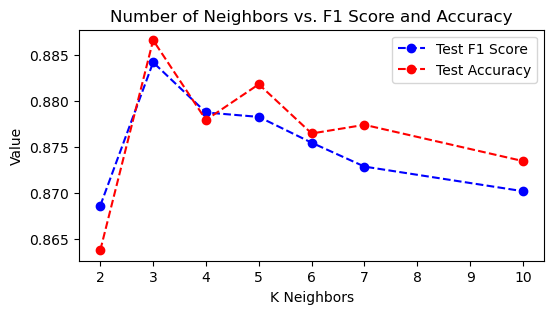

In [124]:
neighbors = [2,3,4,5,6,7,10]
f1_test = [0.8686522739512842, 0.8841839019157115, 0.8787492349283998, 0.878271329869518, 0.8754745047970909, 0.8728833762157182, 0.8702156550449894]
accuracy_test = [0.8638192074493661, 0.8865824625596641, 0.8779392276208235, 0.8818093328173193, 0.8764732786827569, 0.8774114860031196, 0.8734827428491011]
plt.figure(figsize=(6,3))
plt.plot(neighbors, f1_test, '--bo', label = "Test F1 Score")
plt.plot(neighbors, accuracy_test, '--ro', label = "Test Accuracy")
plt.xlabel("K Neighbors")
plt.ylabel("Value")
plt.title("Number of Neighbors vs. F1 Score and Accuracy")
plt.legend(loc='upper right')

Random Forest

In [86]:
params = {
    "n_estimators": 100,
    "max_depth": 20,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9041541015740014
0.9081260481534907


In [87]:
params = {
    "n_estimators": 100,
    "max_depth": 20,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.904658937322451
0.9085834242221675


In [88]:
params = {
    "n_estimators": 100,
    "max_depth": 20,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9053128000573243
0.9092401693464214


In [89]:
params = {
    "n_estimators": 100,
    "max_depth": 25,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9116886733645817
0.9146583166215154


In [90]:
params = {
    "n_estimators": 100,
    "max_depth": 25,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.913148358221152
0.9159718068700231


In [91]:
params = {
    "n_estimators": 100,
    "max_depth": 25,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9136935156075692
0.9165112760792317


In [92]:
params = {
    "n_estimators": 100,
    "max_depth": 30,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.914710407245052
0.9173439350760534


In [93]:
params = {
    "n_estimators": 100,
    "max_depth": 30,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9152024331532227
0.9177661283702166


In [94]:
params = {
    "n_estimators": 100,
    "max_depth": 30,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9158192773568822
0.9182938699879206


In [95]:
params = {
    "n_estimators": 100,
    "max_depth": 35,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9149635221883592
0.9175902144976487


In [96]:
params = {
    "n_estimators": 100,
    "max_depth": 35,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9157843472808584
0.918282142396416


In [97]:
params = {
    "n_estimators": 100,
    "max_depth": 35,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9157904031029812
0.9182235044388933


In [98]:
params = {
    "n_estimators": 100,
    "max_depth": 40,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9149857511610261
0.9175902144976487


In [99]:
params = {
    "n_estimators": 100,
    "max_depth": 40,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9156117320631729
0.918082773340839


In [100]:
params = {
    "n_estimators": 100,
    "max_depth": 40,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9158991505252138
0.918282142396416


In [110]:
params = {
    "n_estimators": 100,
    "max_depth": 45,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9150371598180663
0.9176488524551712


In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 45,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9154317470915192
0.91793031465128


In [111]:
params = {
    "n_estimators": 100,
    "max_depth": 45,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9156146296842488
0.9180124077918118


In [112]:
params = {
    "n_estimators": 100,
    "max_depth": 50,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9151026883144053
0.9176840352296849


In [25]:
params = {
    "n_estimators": 100,
    "max_depth": 50,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9161869263408436
0.9186574253245611


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
cm

array([[13697,  4862],
       [ 2074, 64636]])

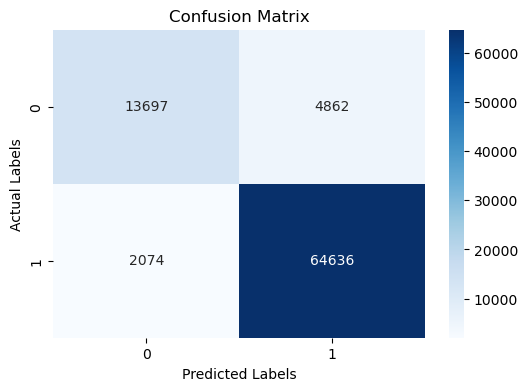

In [27]:
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap='Blues', fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()  

In [114]:
params = {
    "n_estimators": 100,
    "max_depth": 50,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9156205617336063
0.9180124077918118


In [9]:
params = {
    "n_estimators": 100,
    "max_depth": 55,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9150956264798477
0.9176723076381803


In [10]:
params = {
    "n_estimators": 100,
    "max_depth": 55,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.915933349587167
0.9184228734944705


In [11]:
params = {
    "n_estimators": 100,
    "max_depth": 55,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9155885099926808
0.9179889526088028


In [19]:
params = {
    "n_estimators": 100,
    "max_depth": 60,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9156126517029647
0.9180124077918118


In [20]:
params = {
    "n_estimators": 100,
    "max_depth": 60,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.915783502933949
0.9182938699879206


In [21]:
params = {
    "n_estimators": 100,
    "max_depth": 60,
    "min_samples_split": 5,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.9150956264798477
0.9176723076381803


In [24]:
max_depth_2 = [20, 25, 30, 35, 40, 45, 50, 55, 60]
f1_score_2 = [0.9053128000573243, 0.9136935156075692, 0.9158192773568822, 0.9157904031029812, 0.9158991505252138, 0.9156146296842488, 0.9156205617336063, 0.9155885099926808, 0.9156126517029647]
max_depth_3 = [20, 25, 30, 35, 40, 45, 50, 55, 60]
f1_score_3 = [0.904658937322451, 0.913148358221152, 0.9152024331532227, 0.9157843472808584, 0.9156117320631729, 0.9154317470915192, 0.9161869263408436, 0.915933349587167, 0.915783502933949]
max_depth_5 = [20, 25, 30, 35, 40, 45, 50, 55, 60]
f1_score_5 = [0.9041541015740014, 0.9116886733645817, 0.914710407245052, 0.9149635221883592, 0.9149857511610261, 0.9150371598180663, 0.9151026883144053, 0.9150956264798477, 0.9150956264798477]

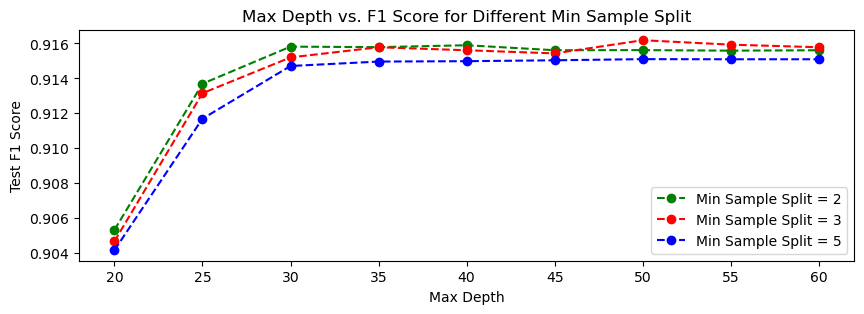

In [25]:
plt.figure(figsize=(10,3))
plt.plot(max_depth_2, f1_score_2, '--go', label = "Min Sample Split = 2")
plt.plot(max_depth_3, f1_score_3, '--ro', label = "Min Sample Split = 3")
plt.plot(max_depth_5, f1_score_5, '--bo', label = "Min Sample Split = 5")
plt.xlabel("Max Depth")
plt.ylabel("Test F1 Score")
plt.title("Max Depth vs. F1 Score for Different Min Sample Split")
plt.legend(loc='lower right')

XGBoost

In [72]:
params = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 2,
}

gb = GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.86369605478033

In [73]:
accuracy_score(y_test, y_pred)

0.8707150312540314

In [12]:
params = {
    "n_estimators": 100,
    "max_depth": 7,
    "min_samples_split": 2,
}

gb = GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.8742465728725136

In [13]:
accuracy_score(y_test, y_pred)

0.8803082011047392

In [14]:
params = {
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 2,
}

gb = GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.8917014328311085

In [15]:
accuracy_score(y_test, y_pred)

0.8962577255509037

In [22]:
params = {
    "n_estimators": 100,
    "max_depth": 12,
    "min_samples_split": 2,
}

gb = GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.9033153344412794

In [23]:
accuracy_score(y_test, y_pred)

0.9066718268069287

In [26]:
params = {
    "n_estimators": 100,
    "max_depth": 15,
    "min_samples_split": 2,
}

gb = GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.9129714284949167

In [27]:
accuracy_score(y_test, y_pred)

0.9153267893372738

In [39]:
params = {
    "n_estimators": 100,
    "max_depth": 20,
    "min_samples_split": 2,
}

gb = GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.9152909971001147

In [40]:
accuracy_score(y_test, y_pred)

0.9176488524551712

In [41]:
params = {
    "n_estimators": 100,
    "max_depth": 15,
    "min_samples_split": 3,
}

gb = GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.9135640323453637

In [42]:
accuracy_score(y_test, y_pred)

0.9159366240955095

In [43]:
params = {
    "n_estimators": 100,
    "max_depth": 20,
    "min_samples_split": 3,
}

gb = GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.9154776427535197

In [44]:
accuracy_score(y_test, y_pred)

0.9178130387362348

In [45]:
params = {
    "n_estimators": 100,
    "max_depth": 30,
    "min_samples_split": 2,
}

gb = GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.8970267291501554

In [46]:
accuracy_score(y_test, y_pred)

0.8992248062015504

#### BOW

In [4]:
from nltk.corpus import stopwords
stop_words = list(set(stopwords.words('english')))

In [5]:
X = df['Summary']
Y = df['Score']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

In [7]:
X_train_nonan=X_train[~X_train.isna()]
X_test_nonan=X_test[~X_test.isna()]

In [8]:
y_train=y_train[~X_train.isna()]
y_test=y_test[~X_test.isna()]

In [9]:
def clean(doc):
    # Removal of punctuation marks (.,/\][{} etc) and numbers
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Removal of stopwords
    doc = " ".join([token for token in doc.split() if token not in stop_words])
    return doc.lower()

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(preprocessor=clean)
X_train_dtm = vect.fit_transform(X_train_nonan)
X_test_dtm = vect.transform(X_test_nonan)

In [11]:
print(X_train_dtm.shape)
print(X_test_dtm.shape)

(483165, 38145)
(85262, 38145)


In [51]:
params = {
    "n_estimators": 100,
    "max_depth": 40,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.5030806652992388
0.64232600689639


In [52]:
params = {
    "n_estimators": 100,
    "max_depth": 100,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.5566386708288089
0.6668621425723066


In [65]:
params = {
    "n_estimators": 100,
    "max_depth": 200,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.6789079652104277
0.735110600267411


In [68]:
params = {
    "n_estimators": 100,
    "max_depth": 300,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7212118916483089
0.7607492200511365


In [14]:
params = {
    "n_estimators": 100,
    "max_depth": 300,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7196057173768712
0.7599399498017875


In [15]:
params = {
    "n_estimators": 100,
    "max_depth": 350,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7307332759289596
0.7662029978184889


In [16]:
params = {
    "n_estimators": 100,
    "max_depth": 400,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7375383950282183
0.7699795923154512


In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 450,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7422628753477506
0.7725129600525439


In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 500,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7460655153340341
0.7744247144097018


In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 600,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7512875482504866
0.7767938823860571


In [20]:
params = {
    "n_estimators": 100,
    "max_depth": 1000,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7582908362775068
0.7790809504820436


In [13]:
params = {
    "n_estimators": 100,
    "max_depth": 2000,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7640657708580214
0.7818723464145809


In [12]:
nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(X_train_dtm, y_train)
y_pred = nn.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7149271938674818
0.7116652201449649


In [14]:
nn = KNeighborsClassifier(n_neighbors=2)
nn.fit(X_train_dtm, y_train)
y_pred = nn.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.6792992606685309
0.6600478525017006


In [13]:
nn = KNeighborsClassifier(n_neighbors=3)
nn.fit(X_train_dtm, y_train)
y_pred = nn.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7256831701653538
0.7326945180737022


In [16]:
nn = KNeighborsClassifier(n_neighbors=5)
nn.fit(X_train_dtm, y_train)
y_pred = nn.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7230358060049208
0.7358260420820529


In [17]:
nn = KNeighborsClassifier(n_neighbors=4)
nn.fit(X_train_dtm, y_train)
y_pred = nn.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7229239930816906
0.7291642232178461


In [18]:
nn = KNeighborsClassifier(n_neighbors=10)
nn.fit(X_train_dtm, y_train)
y_pred = nn.predict(X_test_dtm)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7093524158215425
0.7300086791302104


#### Binary

In [12]:
y_test_bi = np.where(y_test > 3, 1, 0)
y_train_bi = np.where(y_train > 3, 1, 0)

In [23]:
nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(X_train_dtm, y_train_bi)
y_pred = nn.predict(X_test_dtm)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.8895688557309022
0.8891768900565317


In [ ]:
nn = KNeighborsClassifier(n_neighbors=2)
nn.fit(X_train_dtm, y_train_bi)
y_pred = nn.predict(X_test_dtm)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.8702161967285844
0.8645469259459079


In [ ]:
nn = KNeighborsClassifier(n_neighbors=3)
nn.fit(X_train_dtm, y_train_bi)
y_pred = nn.predict(X_test_dtm)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.8986314069810654
0.9005770448734489


In [ ]:
nn = KNeighborsClassifier(n_neighbors=4)
nn.fit(X_train_dtm, y_train_bi)
y_pred = nn.predict(X_test_dtm)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.8855484270968871
0.883957683375947


In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 500,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train_bi)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.9046917928477467
0.9094555605076118


In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 1000,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train_bi)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.9130491025327723
0.9157303370786517


In [ ]:
params = {
    "n_estimators": 100,
    "max_depth": 2000,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train_bi)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.915600711773248
0.9175130773380873


In [30]:
params = {
    "n_estimators": 100,
    "max_depth": 2000,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train_bi)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.9163396548874571
0.9183458046961132


In [31]:
params = {
    "n_estimators": 100,
    "max_depth": 3000,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train_bi)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.9171256780359088
0.9186507471089114


In [32]:
params = {
    "n_estimators": 100,
    "max_depth": 3000,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm, y_train_bi)
y_pred = rf.predict(X_test_dtm)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.9181498887345723
0.9198118739884122


#### Reduce Size of Vector

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features= 5000, preprocessor=clean)
X_train_dtm_small = vect.fit_transform(X_train_nonan)
X_test_dtm_small = vect.transform(X_test_nonan)

In [33]:
print(X_train_dtm_small.shape)
print(X_test_dtm_small.shape)

(483165, 5000)
(85262, 5000)


In [15]:
params = {
    "n_estimators": 100,
    "max_depth": 100,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm_small, y_train)
y_pred = rf.predict(X_test_dtm_small)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.6572087553379327
0.7211536206047242


In [16]:
params = {
    "n_estimators": 100,
    "max_depth": 500,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm_small, y_train)
y_pred = rf.predict(X_test_dtm_small)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7447293134798326
0.7695925500222842


In [17]:
params = {
    "n_estimators": 100,
    "max_depth": 1000,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm_small, y_train)
y_pred = rf.predict(X_test_dtm_small)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7543098552509441
0.7737679153667519


In [18]:
params = {
    "n_estimators": 100,
    "max_depth": 1000,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm_small, y_train)
y_pred = rf.predict(X_test_dtm_small)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7557915943166011
0.7759259693650161


In [14]:
nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(X_train_dtm_small, y_train)
y_pred = nn.predict(X_test_dtm_small)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7100409383569322
0.708439867701907


In [34]:
nn = KNeighborsClassifier(n_neighbors=2)
nn.fit(X_train_dtm_small, y_train)
y_pred = nn.predict(X_test_dtm_small)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.6694817534905223
0.651568107715043


In [35]:
nn = KNeighborsClassifier(n_neighbors=3)
nn.fit(X_train_dtm_small, y_train)
y_pred = nn.predict(X_test_dtm_small)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7140628220879688
0.7223264760385635


In [36]:
nn = KNeighborsClassifier(n_neighbors=4)
nn.fit(X_train_dtm_small, y_train)
y_pred = nn.predict(X_test_dtm_small)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.719369722108346
0.728472238511881


In [37]:
nn = KNeighborsClassifier(n_neighbors=5)
nn.fit(X_train_dtm_small, y_train)
y_pred = nn.predict(X_test_dtm_small)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7237863755579702
0.7407989491215313


In [14]:
nn = KNeighborsClassifier(n_neighbors=7)
nn.fit(X_train_dtm_small, y_train)
y_pred = nn.predict(X_test_dtm_small)
print(f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_test, y_pred))

0.7186536840530705
0.7420890900987545


In [38]:
nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(X_train_dtm_small, y_train_bi)
y_pred = nn.predict(X_test_dtm_small)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.886828189117084
0.8879805775140156


In [39]:
nn = KNeighborsClassifier(n_neighbors=2)
nn.fit(X_train_dtm_small, y_train_bi)
y_pred = nn.predict(X_test_dtm_small)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.8655292129127704
0.8596561187867984


In [40]:
nn = KNeighborsClassifier(n_neighbors=3)
nn.fit(X_train_dtm_small, y_train_bi)
y_pred = nn.predict(X_test_dtm_small)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.8929880764071071
0.8954282095188947


In [41]:
nn = KNeighborsClassifier(n_neighbors=4)
nn.fit(X_train_dtm_small, y_train_bi)
y_pred = nn.predict(X_test_dtm_small)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.8891116734995297
0.8892589899369003


In [42]:
nn = KNeighborsClassifier(n_neighbors=5)
nn.fit(X_train_dtm_small, y_train_bi)
y_pred = nn.predict(X_test_dtm_small)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.8919020728247016
0.8956275949426473


In [16]:
nn = KNeighborsClassifier(n_neighbors=7)
nn.fit(X_train_dtm_small, y_train_bi)
y_pred = nn.predict(X_test_dtm_small)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.8883008544916128
0.8929769416621707


In [43]:
params = {
    "n_estimators": 100,
    "max_depth": 500,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm_small, y_train_bi)
y_pred = rf.predict(X_test_dtm_small)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.9039803361066313
0.9078722056719288


In [44]:
params = {
    "n_estimators": 100,
    "max_depth": 1000,
    "min_samples_split": 2,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm_small, y_train_bi)
y_pred = rf.predict(X_test_dtm_small)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.9099282929044692
0.9123876990922098


In [45]:
params = {
    "n_estimators": 100,
    "max_depth": 1000,
    "min_samples_split": 3,
    "random_state" : 42
}

rf = RandomForestClassifier(**params)
rf.fit(X_train_dtm_small, y_train_bi)
y_pred = rf.predict(X_test_dtm_small)
print(f1_score(y_test_bi, y_pred, average='weighted'))
print(accuracy_score(y_test_bi, y_pred))

0.9108364346094692
0.9133611691022965
